# Haciendola de jamón

## Idea general
Trás un vistazo rápido a los datos, son 28 observaciones con *calificación* y 11 por calificar (predecir). Las variables no son descriptivas (v1, v2, y v3), dificultando la creación de variables a partir de ellas (más alla de las más simples, o las automáticas); otro reto es la cantidad de observaciones. 

Estandarizaré cada una de las variables (resto el promedio, y divido entre la desviación estandar), para limitar el efecto de la escala de las variables; posteriormente añadire las interacciones de las variables (v1 x v2, v1 x v3, y v2 x v3). 

Dado la cantidad pequeña de observaciones (esto es relativo) usaré todos los datos para buscar el mejor modelo predictivo, reportando el error de la validación cruzada. Las buenas practicas indican separar el dataset en dos, train y test, usar el primero para ajustar el modelo, y el segundo para evaluar su desempeño; sin embargo, hay excepciones a esa regla, una de ellas es cuando las observaciones son pocas, reflexione sobre está decisión en particular, pues mi libertad depende de ella.

Probaré modelar los datos con una **regresión linear por mínimos cuadrados con una regularización l_2**, a los mismos datos ajustaré un **random forest**, un método más elaborado que usualmente generá buenas predicciones; evaluaré su poder predictivo con el ** raíz del error cuadrático medio** (rmse), eligiendo aquella con el valor más bajo. Para estás dos aproximaciones probaré diferentes hiperparametros, y usaré validación cruzada.

In [1]:
# dependencias
import numpy  as np
import pandas as pd
from   seaborn import scatterplot
from   sklearn.preprocessing   import StandardScaler, PolynomialFeatures
from   sklearn.model_selection import GridSearchCV
from   sklearn.linear_model    import Ridge
from   sklearn.ensemble        import RandomForestRegressor
from   sklearn.metrics         import make_scorer, mean_squared_error

In [2]:
# data paths
path_jamon_historico = 'work/datasets/score_de_jamonosidad.csv'
path_jamon_nuevos    = 'work/datasets/jamones_por_calificar.csv'
# data output
path_jamon_salida    = 'work/datasets/jamones_por_calificar_con_predicciones.csv'

In [3]:
# data loading
jamones_calificados = pd.read_csv(path_jamon_historico)
jamones_nuevos      = pd.read_csv(path_jamon_nuevos)

In [4]:
## vistazo inicial
# son pocos registros, imprimó todos
jamones_calificados

,jamon,score,v1,v2,v3
0,1,10,1985,59.7,2205
1,2,11,2855,55.0,2096
2,3,11,1737,65.6,1847
3,4,13,2905,61.4,1903
4,5,10,1666,66.1,1457
5,6,11,2927,61.0,1848
6,7,10,2341,66.1,1564
7,8,11,2737,58.9,2476
8,9,4,1414,57.0,2577
9,10,2,1838,58.9,2476


**jamón** es el id, **score** es la calificación obtenida, **v1**, **v2**, y **v3**, son variables de los especimenes; no hay valores faltantes u extraños, e.g 9999, -1.

In [5]:
# estadística descriptiva
jamones_calificados.describe()

,jamon,score,v1,v2,v3
count,28.000000,28.000000,28.000000,28.000000,28.000000
mean,14.500000,6.964286,2127.214286,58.296429,2132.964286
std,8.225975,3.479912,499.116134,5.457342,367.711288
min,1.000000,0.000000,1414.000000,43.800000,1457.000000
25%,7.750000,4.000000,1714.000000,54.775000,1887.750000
50%,14.500000,6.500000,2106.000000,58.850000,2062.500000
75%,21.250000,10.000000,2474.250000,61.100000,2427.250000
max,28.000000,13.000000,2929.000000,68.500000,2876.000000


### Separación en train and test
Las buenas prácticas indican separar los datos en dos subconjuntos, train y test, el primero para entrenar el modelo y el segundo para evaluarlo. Sin embargo, hay excepciones a la regla, una de ellas es cuando los datos son pocos, como en esté desafío; reportaré el *cross-validation error* (pense detenidamente esto, pues mi libertad está en juego).



In [6]:
# llevo los datos a un formato para scikit-learn
columnas_predictoras = ['v1', 'v2', 'v3']
columna_objetivo     = ['score']
# separación
predictores = jamones_calificados[columnas_predictoras]
objetivo    = jamones_calificados[columna_objetivo]

<AxesSubplot:xlabel='v1', ylabel='v2'>

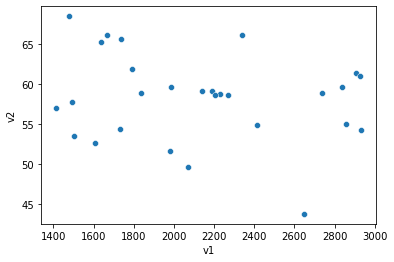

In [7]:
# gráficas de dispersión
scatterplot(data = predictores, x = 'v1', y = 'v2')

<AxesSubplot:xlabel='v2', ylabel='v3'>

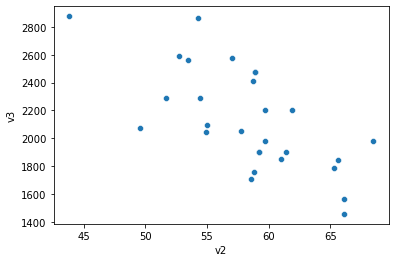

In [8]:
scatterplot(data = predictores, x = 'v2', y = 'v3')

<AxesSubplot:xlabel='v1', ylabel='v3'>

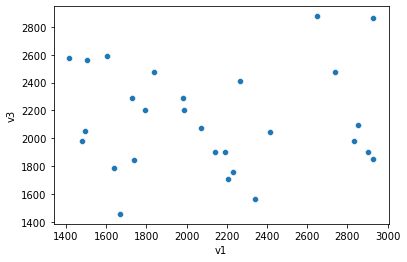

In [9]:
scatterplot(data = predictores, x = 'v1', y = 'v3')

## Ingeniería de variables
Las 3 variables predictoras son númericas, las standarizaré, y agregaré las interacciones.

In [10]:
# estandarización: después de esta transformación las variables tendrán promedio 0 y desviación estandar 1
# ajuste
estandarizador = StandardScaler(with_mean = True, with_std = True).fit(predictores)
# transformación
predictores_estandarizados = estandarizador.transform(predictores)

In [11]:
# añado las interacciones, v1 * v2, v2 * v3, y v1 * v3
# ajuste
poly = PolynomialFeatures(interaction_only = True, include_bias = False).fit(predictores_estandarizados)
# transformación
predictores_con_interacciones = poly.transform(predictores_estandarizados)

## Modelado

Probaré un algoritmo relativamente sencillo, una **regresión linear por mínimos cuadrados con una regularización l_2**, y uno más elaborado, un **Random Forest**, explorando el espacio de hiperparametros correspondiente, usando **validación cruzada**, y **rmse** para la evaluación.

In [12]:
# función para evaluación, la pide GridSearchCV
def rmse_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared = False)
#
scorer_rmse = make_scorer(rmse_error, greater_is_better = False)

### Regresión lineal

In [13]:
# espacio de hiperparametros a probar, en este caso es solo la fuerza de la regularización, alpha
parameters_linear = {'alpha': [0.1, .3, 1, 3, 10]}
#
modelo_linear = GridSearchCV(Ridge(fit_intercept = True, solver = 'lsqr', random_state = 42), param_grid = parameters_linear, n_jobs = 6, cv = 4, scoring = scorer_rmse)
# ajuste del modelo
modelo_linear.fit(X = predictores_con_interacciones, y =  objetivo)
# extraigó el mejor modelo
modelo_linear_mejor = modelo_linear.best_estimator_
# vistazo rápido
print(modelo_linear_mejor)
print(np.abs(modelo_linear.best_score_))

Ridge(alpha=1, random_state=42, solver='lsqr')
2.061611556799242


### Random Forest

In [14]:
# espacio de hiperparametros a probar
parameters_rf = {'n_estimators': [10, 20, 50], 'max_depth': [2, 5], 'max_features': [2, 5]}
# ajuste y evaluación
modelo_random_forest = GridSearchCV(RandomForestRegressor(random_state = 42, criterion = 'mse', n_jobs = 1), param_grid = parameters_rf, n_jobs = 6, cv = 4, scoring = scorer_rmse)
# ajuste del modelo
modelo_random_forest.fit(X = predictores_con_interacciones, y =  objetivo)
# extraigo el mejor modelo
modelo_random_forest_mejor = modelo_random_forest.best_estimator_
# ojeada
print(modelo_random_forest_mejor)
print(np.abs(modelo_random_forest.best_score_))

RandomForestRegressor(max_depth=5, max_features=5, n_estimators=20, n_jobs=1,
                      random_state=42)
2.912955188810901
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


### Selección del modelo
El modelo con el mejor desempeño (menor rmse en la validación cruzada) fue la regresión lineal regularizada, con un `rmse = 2.06`, lo usaré para hacer predicciones de los jamones no calificados.

In [15]:
# elijó aquel modelo con mejor desempeño, aquél con rmse más bajo
if (np.abs(modelo_linear.best_score_) < np.abs(modelo_random_forest.best_score_)):
    modelo_mejor = modelo_linear_mejor
else:
    modelo_mejor = modelo_random_forest_mejor

## Preparación para la calificación de los nuevos jamones
Aplico los pasos de preprocesado, e ingeniería de variables.

In [16]:
# preparación de la información de los jamones no calificados
# estandarización
jamones_nuevos_estandarizados    = estandarizador.transform(jamones_nuevos[columnas_predictoras])
# add interactions
jamones_nuevos_con_interacciones = poly.transform(jamones_nuevos_estandarizados)

In [17]:
# ahora uso el mejor modelo (regression linear regularizada) para hacer predicciones de los nuevos jamones
predicciones = modelo_linear_mejor.predict(jamones_nuevos_con_interacciones)

In [18]:
# vistazo de las predicciones
print(predicciones)
# son las mejores que tenemos hasta el momento; para honrar más el espiritu del jurado, las redondearé al entero más cercano, justo como los jueces califican
predicciones_redondeadas = np.rint(predicciones)
# 
print(predicciones_redondeadas)

[[ 9.21532175]
 [ 3.47584764]
 [12.78281518]
 [ 6.96170729]
 [ 9.07067488]
 [ 3.39432919]
 [ 5.19976766]
 [10.61943072]
 [ 8.17055424]
 [10.22461983]
 [ 9.95675846]]
[[ 9.]
 [ 3.]
 [13.]
 [ 7.]
 [ 9.]
 [ 3.]
 [ 5.]
 [11.]
 [ 8.]
 [10.]
 [10.]]


### Salida
Preparo la tabla de salida

In [19]:
# añado las predicciones
df_salida = jamones_nuevos
df_salida['score'] = predicciones_redondeadas

In [20]:
# imprimo los resultados antes de exportarlos
df_salida

,jamon,score,v1,v2,v3
0,29,9.0,2383,59,1857
1,30,3.0,1598,61,2696
2,31,13.0,2883,67,1865
3,32,7.0,2898,56,2822
4,33,9.0,2877,44,1553
5,34,3.0,1966,55,2683
6,35,5.0,1786,66,2823
7,36,11.0,2813,63,2199
8,37,8.0,2882,52,2187
9,38,10.0,2859,49,1498


In [21]:
# salvado como csv
df_salida.to_csv(path_jamon_salida, index = False)

## Conclusiones

Implemente una solución sensible a las circunstancias, e.g. cantidad de información, descripción de las variables, explorando el espacio de un par de modelos (grid search), usando el **rmse** para encontrar el mejor modelo predictivo.